# Data Preparation: Internal (NPO)

In [ ]:
import bigframes.pandas as bf
import pandas as pd
import matplotlib.pyplot as plt

bf.options.bigquery.location = "eu"
bf.options.bigquery.project = "datamart-ads-students-2024"

<ipython-input-1-0f8e2f8244c6>:8: UnknownLocationWarning: The location 'eu' is set to an unknown value. Did you mean 'US'?
  bf.options.bigquery.location = "eu" #this variable is set based on the dataset you chose to query


## Popularity

In [ ]:
#The dataset contains impressions over the entire platform, what are the different locations?
bf.read_gbq("""
SELECT DISTINCT rec_panel_location
FROM `datamart-ads-students-2024.npo_intermediary_topspin_engaged_impressions.v1`
ORDER BY rec_panel_location;
""")

,rec_panel_location
0,ontdek
1,zoek
2,fragmenten
3,auth
4,aflevering
5,omroep
6,speellijsten
7,programmas
8,voorwaarden
9,gids


In [ ]:
#This query calculates the percentage of total views on the homepage coming from the popular lane, on a certain day
df_popular = bf.read_gbq("""
WITH
  popular AS (
  SELECT
    DATE(logged_timestamp_minute) AS date,
    SUM(n_views) AS views
  FROM
    `datamart-ads-students-2024.npo_intermediary_topspin_engaged_impressions.v1`
  WHERE
    DATE(logged_timestamp_minute) BETWEEN '2023-12-01' AND '2024-05-31'
    AND has_view > 0
    AND rec_panel LIKE 'popular-%'  --is always on the home screen so no need to code that again
    AND platform_type = 'site'
  GROUP BY
    DATE(logged_timestamp_minute) ),

  total AS (
  SELECT
    DATE(logged_timestamp_minute) AS date,
    SUM(n_views) AS views
  FROM
    `datamart-ads-students-2024.npo_intermediary_topspin_engaged_impressions.v1`
  WHERE
    DATE(logged_timestamp_minute) BETWEEN '2023-12-01' AND '2024-05-31'
    AND has_view > 0
    AND rec_panel_location = 'home'
    AND platform_type = 'site'
  GROUP BY
    DATE(logged_timestamp_minute) )
SELECT
  popular.date,
IF
  (total.views > 0, (popular.views / total.views) * 100, 0) AS popularity
FROM
  popular
JOIN
  total
ON
  popular.date = total.date
ORDER BY date
                 """)

df_popular = df_popular.sort_values(by='date')  #idk why but the ORDER BY date clause is not working so I do it again here
df_popular

,date,popularity
30,2023-12-01,2.49661
132,2023-12-02,2.51702
26,2023-12-03,2.290707
50,2023-12-04,2.519299
69,2023-12-05,2.317921
181,2023-12-06,2.591331
60,2023-12-07,2.772241
112,2023-12-08,2.415627
140,2023-12-09,2.776096
57,2023-12-10,3.416819


## ECTR
The Engaged Click-Through Rate (ECTR), is calculated by the amount of views divided by the amount of impressions/offers. A view is defined as when a user clicked the video and watched at least one minute.

In [ ]:
#Let's first check what the data looks like, since the ectr already is a variable that does not need to be computed anymore
test = bf.read_gbq("""
SELECT processed_date, AVG(engaged_ctr)*100 as ectr, subscription_type
FROM `datamart-ads-students-2024.npo_diaz_dashboard_page_daily.v2`
WHERE processed_date BETWEEN '2023-12-01' AND '2024-05-31' AND platform_type = 'site'
GROUP BY processed_date, subscription_type
ORDER BY processed_date
""")
test.sort_values(by='processed_date')

#It seems to be that there is a lot of difference between anonymous and premium users in terms of ectr, let's make a plot for some clarity!

,processed_date,ectr,subscription_type
80,2023-12-01,33.946925,premium
460,2023-12-01,2.402295,anonymous
116,2023-12-02,2.223302,anonymous
423,2023-12-02,33.85487,premium
58,2023-12-03,34.55161,premium
272,2023-12-03,2.391494,anonymous
238,2023-12-04,36.180051,premium
395,2023-12-04,3.880165,anonymous
472,2023-12-05,35.95804,premium
491,2023-12-05,4.743069,anonymous


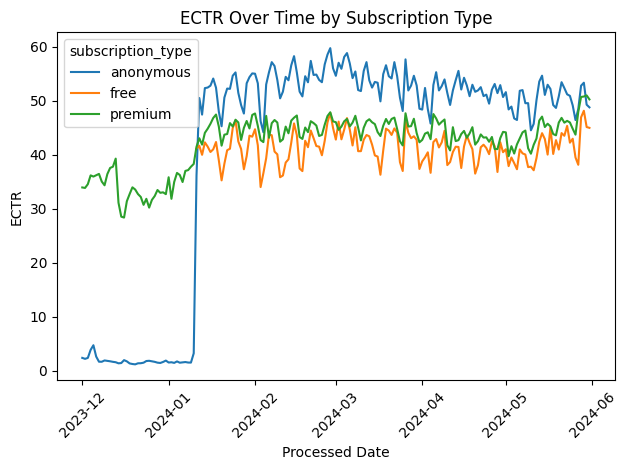

<Figure size 640x480 with 0 Axes>

In [ ]:
#Plot of ECTR over time (some EDA)
pivot_df = test.pivot(index='processed_date', columns='subscription_type', values='ectr')
pivot_df.plot(kind='line')
plt.title('ECTR Over Time by Subscription Type')
plt.xlabel('Processed Date')
plt.ylabel('ECTR')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

Up to January 10th there seems to be something wrong with the data, but we will lose a lot of daily data if we delete everything before. Let's therefore focus on logged in users only, i.e. premium and free. However, with this we also drop a large group of users but other wise two features will be useless since they happened before the 11th.

In [4]:
#Final dataframe with variable of interest ECTR
df_ectr = bf.read_gbq("""
  SELECT
    processed_date AS date,
    AVG(engaged_ctr)*100 AS ectr
  FROM
    `datamart-ads-students-2024.npo_diaz_dashboard_page_daily.v2`
  WHERE
    processed_date BETWEEN '2023-12-01' AND '2024-05-31'
    AND platform_type = 'site' AND NOT subscription_type = 'anonymous'
  GROUP BY processed_date
  ORDER BY processed_date
""")

df_ectr = df_ectr.sort_values(by='date')
df_ectr

,date,ECTR
16,2023-12-01,33.946925
165,2023-12-02,33.85487
174,2023-12-03,34.55161
46,2023-12-04,36.180051
159,2023-12-05,35.95804
96,2023-12-06,36.199659
138,2023-12-07,36.451538
107,2023-12-08,35.033713
143,2023-12-09,34.343296
28,2023-12-10,36.418816


## Diversity
To calculate the diversity ('distribution of broadcasters from the impressions on the homepage'), it is needed to merge the impressions and metadata table. Not all variables need to be included to the derive the diversity, but the following are necessary to make calculations/aggregations:

From **npo_intermediary_topspin_engaged_impressions.v1**:
*   logged_timestamp_minute
*   rec_panel_location
*   rec_panel
*   rec_destination_poms_id

From **npo_diaz_search_processed.latest_metadata_as_processed_for_search**:
*   series_guid
*   mid
*   series_id
*   broadcasters

\\

The table contains data on both series and episodes. Therefore we need to join using COALESCE.

rec_destination_poms_id == series_id OR rec_destination_poms_id == mid

In [ ]:
#Let's first do it for one day and check out the different broadcasters!
df_count_br = bf.read_gbq("""
WITH poms_freq AS (
  -- This query gives the frequency of all poms_ids (now only for 01/12)
  SELECT
      DATE(logged_timestamp_minute) AS date,
      rec_destination_poms_id,
      COUNT(rec_panel) AS count_poms
  FROM
      `datamart-ads-students-2024.npo_intermediary_topspin_engaged_impressions.v1`
  WHERE
      DATE(logged_timestamp_minute) = '2023-12-01'
      AND rec_panel_location = 'home'
  GROUP BY
      DATE(logged_timestamp_minute), rec_destination_poms_id
),
joined_data AS (
  -- This query joins poms_freq with the metadata
  SELECT
    t1.date,
    t1.rec_destination_poms_id,
    t1.count_poms,
    t2.series_id,
    t2.mid,
    t2.broadcasters,
    t2.genres,
    t2.subgenres
  FROM
    poms_freq t1
  LEFT JOIN
    `datamart-ads-students-2024.npo_diaz_search_processed.latest_metadata_as_processed_for_search` t2
  ON
    t1.rec_destination_poms_id = COALESCE(t2.mid, t2.series_id)
),
unnested_data AS (
  -- This query unnests the broadcasters such that we can group them
  SELECT
    date,
    rec_destination_poms_id,
    count_poms,
    broadcaster
  FROM
    joined_data,
    UNNEST(broadcasters) AS broadcaster
)
-- Final table
SELECT
  broadcaster,
  SUM(count_poms) AS count
FROM
  unnested_data
GROUP BY
  broadcaster
""")

df_count_br

,broadcaster,count
0,WNL,267711
1,EO,282340
2,TROS,1652
3,RKK,43
4,NOS,888282
5,VPRO,426556
6,MAX,444030
7,LLiNK,10
8,Omroep Zwart,969
9,VARA,2000


The NPO communicates that there are 15 broadcasters on their website but there are many more. Let's check all occuring broadcasters and see if we need to merge them or drop some. The Shannon entropy ('diversity') namely takes into account the total amount of broadcasters and if there really are so many, the diversity will never be high because there are very small or old broadcasters that occur very little. See for instance Socutera (count = 10) above.

In [ ]:
#What are all occuring broadcasters?
bf.read_gbq("""
SELECT DISTINCT broadcaster
FROM `datamart-ads-students-2024.npo_diaz_search_processed.latest_metadata_as_processed_for_search`,
  UNNEST(broadcasters) AS broadcaster
""")

,broadcaster
0,PowNed
1,LLiNK
2,AVROTROS
3,Omroep Flevoland
4,Teleac
5,RTV Noord
6,VPRO
7,NIO
8,BNNVARA
9,NPO Zappelin


There are even 63 in the entire metadata! That means that we have to merge, drop very small ones. I see that there are some that can easily be merged. For example, BNN and VARA were separate broadcasters but are combined now. The appendix of the paper contains explanation of each broadcaster. We end up with 13 original broadcasters and two new combinations: regional and NPO.

In [2]:
bf.read_gbq("""
SELECT DISTINCT broadcaster
FROM `datamart-ads-students-2024.npo_diaz_search_processed.latest_metadata_as_processed_for_search`,
  UNNEST(broadcasters) AS broadcaster
""")

,broadcaster
0,PowNed
1,LLiNK
2,AVROTROS
3,Omroep Flevoland
4,Teleac
5,RTV Noord
6,VPRO
7,NIO
8,BNNVARA
9,NPO Zappelin


In [5]:
#Final dataframe with variable of interest diversity
df_join = bf.read_gbq("""
WITH poms_freq AS (
  -- Calculate the frequency of all poms_ids
  SELECT
      DATE(logged_timestamp_minute) AS date,
      rec_destination_poms_id,
      COUNT(rec_panel) AS count_poms
  FROM
      `datamart-ads-students-2024.npo_intermediary_topspin_engaged_impressions.v1`
  WHERE
      DATE(logged_timestamp_minute) BETWEEN '2023-12-01' AND '2024-05-31'
      AND rec_panel_location = 'home'
      AND platform_type = 'site'
  GROUP BY
      DATE(logged_timestamp_minute), rec_destination_poms_id
),
joined_data AS (
  -- Join poms_freq with metadata
  SELECT
    t1.date,
    t1.rec_destination_poms_id,
    t1.count_poms,
    t2.series_id,
    t2.mid,
    t2.broadcasters,
    t2.genres,
    t2.subgenres
  FROM
    poms_freq t1
  LEFT JOIN
    `datamart-ads-students-2024.npo_diaz_search_processed.latest_metadata_as_processed_for_search` t2
  ON
    t1.rec_destination_poms_id = COALESCE(t2.mid, t2.series_id)
),
unnested_data AS (
  -- Unnest broadcasters for grouping, filtering and merging
  SELECT
    date,
    rec_destination_poms_id,
    count_poms,
    CASE
      WHEN broadcaster IN ('BNN', 'VARA') THEN 'BNNVARA'
      WHEN broadcaster IN ('KRO', 'NCRV', 'RKK', 'BOS') THEN 'KRO-NCRV'
      WHEN broadcaster IN ('AVRO', 'TROS') THEN 'AVROTROS'
      WHEN broadcaster IN ('ZvK', 'IKON', 'Joodse Omroep') THEN 'EO'
      WHEN broadcaster IN ('Teleac', 'Moslim Omroep', 'NPS', 'RVU', 'NMO') THEN 'NTR'
      WHEN broadcaster IN ('NPO Zapp', 'NPO Zappelin', 'NPO Radio 5', 'NPO 1', 'NPO 2', 'NPO Radio 1', 'NPO 3', 'NPO Radio 2', 'BVN') THEN 'NPO'
      WHEN broadcaster IN ('TV Gelderland', 'Omrop Fryslân', 'RTV Drenthe', 'Omroep Zeeland', 'RTV Rijnmond', 'Omroep Brabant', 'RTV Noord', 'Omroep West', 'L1', 'RTV Noord Holland', 'RTV Utrecht', 'RTV Oost', 'Omroep Flevoland') THEN 'regional'
      WHEN broadcaster IN ('Polygoon', 'Socutera', 'VRT', 'Politieke partijen', 'FunX', 'NIO', 'LLiNK', 'OHM', 'NPO 3FM', 'Radio Nederland Wereldomroep', 'Stichting Ether Reclame') THEN NULL
      ELSE broadcaster
    END AS broadcaster
  FROM
    joined_data,
    UNNEST(broadcasters) AS broadcaster
),
broadcaster_counts AS (
  -- Calculate total count per broadcaster per day
  SELECT
    date,
    broadcaster,
    SUM(count_poms) AS count
  FROM
    unnested_data
  WHERE
    broadcaster IS NOT NULL
  GROUP BY
    date, broadcaster
),
probability_calculations AS (
  -- Calculate probability and intermediate entropy values
  SELECT
    bc.date,
    bc.broadcaster,
    bc.count,
    dt.impression_count,
    bc.count / dt.impression_count AS probability,
    (bc.count / dt.impression_count) * LOG(2, bc.count / dt.impression_count) AS entropy
  FROM
    broadcaster_counts bc
  JOIN (
    SELECT
      date,
      SUM(count) AS impression_count
    FROM
      broadcaster_counts
    GROUP BY
      date
  ) dt
  ON
    bc.date = dt.date
)
-- Final query to select entropy per day
SELECT
  date,
  -SUM(entropy) AS diversity
FROM
  probability_calculations
GROUP BY
  date
ORDER BY
  date;
""")

df_join

,date,diversity
0,2024-04-10,0.322593
1,2024-05-17,0.313822
2,2024-01-14,0.344359
3,2023-12-29,0.367329
4,2024-05-12,0.32941
5,2024-02-08,0.328802
6,2024-02-15,0.329531
7,2024-01-29,0.343959
8,2024-02-21,0.327552
9,2023-12-28,0.369811


## Merge all predictors of interest into one dataframe

In [16]:
df_npo = df_ectr.join(df_popular.set_index('date'), on='date') #join ectr and popularity
df_npo = df_npo.join(df_join.set_index('date'), on='date') #join diversity with above
df_npo

,date,ECTR,popularity,diversity
55,2024-05-24,44.104234,3.831694,0.318503
91,2024-05-25,43.883991,4.272108,0.318822
64,2024-05-26,41.606627,4.354058,0.326317
167,2024-05-27,43.039861,3.759117,0.334234
115,2024-05-28,48.814565,3.397185,0.326055
68,2024-05-29,49.458339,3.352999,0.324324
113,2024-05-30,48.054844,3.317702,0.32376
100,2024-05-31,47.609637,2.858536,0.31492


# Data preparation: External

In [ ]:
#Load external data
df_knmi = pd.read_csv('KNMI.txt', names=['STN', 'date', 'temperature', 'sun', 'rain'], skiprows=1)
df_knmi

,STN,date,temperature,sun,rain
0,209,20231201,,,
1,209,20231202,,,
2,209,20231203,,,
3,209,20231204,,,
4,209,20231205,,,
...,...,...,...,...,...
8596,391,20240527,149,27,62
8597,391,20240528,142,41,58
8598,391,20240529,151,40,51
8599,391,20240530,139,30,9


In [ ]:
#Format variables
df_knmi['date'] = pd.to_datetime(df_knmi['date'], format='%Y%m%d')
df_knmi['temperature'] = pd.to_numeric(df_knmi['temperature'], errors='coerce')
df_knmi['temperature'] = df_knmi['temperature'].div(10)
df_knmi['sun'] = pd.to_numeric(df_knmi['sun'], errors='coerce')
df_knmi['rain'] = pd.to_numeric(df_knmi['rain'], errors='coerce')
df_knmi['rain'] = df_knmi['rain'].mul(6)    #minutes instead of hours
df_knmi

,STN,date,temperature,sun,rain
0,209,2023-12-01,NaN,NaN,NaN
1,209,2023-12-02,NaN,NaN,NaN
2,209,2023-12-03,NaN,NaN,NaN
3,209,2023-12-04,NaN,NaN,NaN
4,209,2023-12-05,NaN,NaN,NaN
...,...,...,...,...,...
8596,391,2024-05-27,14.9,27.0,372.0
8597,391,2024-05-28,14.2,41.0,348.0
8598,391,2024-05-29,15.1,40.0,306.0
8599,391,2024-05-30,13.9,30.0,54.0


## Temperature, sun, rain

In [ ]:
#Average temperature/sun/rain over entire country, data per station (STD) is not relevant
temp_average = df_knmi.groupby('date')['temperature'].mean()
sun_average = df_knmi.groupby('date')['sun'].mean()
rain_average = df_knmi.groupby('date')['rain'].mean()

df_final = pd.concat([rain_average, sun_average, temp_average], axis=1)
df_final.reset_index(inplace=True)
df_final

,date,rain,sun,temperature
0,2023-12-01,9.090909,40.93750,-1.144118
1,2023-12-02,29.818182,40.12500,-0.247059
2,2023-12-03,222.545455,30.96875,0.823529
3,2023-12-04,349.272727,5.40625,1.747059
4,2023-12-05,254.181818,1.43750,1.926471
...,...,...,...,...
178,2024-05-27,139.818182,35.18750,14.611765
179,2024-05-28,357.636364,43.53125,14.394118
180,2024-05-29,302.181818,33.50000,14.923529
181,2024-05-30,50.909091,30.15625,14.364706


## Day type and holiday

In [ ]:
#Add day of the week
df_final.insert(1, 'day_type', df_final['date'].dt.day_name())

#Add holidays
holiday_dates = ['2023-12-25', '2023-12-26', '2024-01-01', '2024-03-29', '2024-03-31', '2024-04-01', '2024-04-27', '2024-05-05', '2024-05-09', '2024-05-19', '2024-05-20']
    #These have been obtained from the website https://www.government.nl/topics/working-hours/question-and-answer/public-holidays-in-the-netherlands
holiday_dates = pd.to_datetime(holiday_dates)
df_final.insert(2, 'holiday', 0)
df_final.loc[df_final['date'].isin(holiday_dates), 'holiday'] = 1
df_final

,date,day_type,holiday,rain,sun,temperature
0,2023-12-01,Friday,0,9.090909,40.93750,-1.144118
1,2023-12-02,Saturday,0,29.818182,40.12500,-0.247059
2,2023-12-03,Sunday,0,222.545455,30.96875,0.823529
3,2023-12-04,Monday,0,349.272727,5.40625,1.747059
4,2023-12-05,Tuesday,0,254.181818,1.43750,1.926471
...,...,...,...,...,...,...
178,2024-05-27,Monday,0,139.818182,35.18750,14.611765
179,2024-05-28,Tuesday,0,357.636364,43.53125,14.394118
180,2024-05-29,Wednesday,0,302.181818,33.50000,14.923529
181,2024-05-30,Thursday,0,50.909091,30.15625,14.364706


## Feature releases

In [ ]:
features = [
    'feature_autoplay',
    'feature_pb_search',
    'feature_pb_recommendations',
    'feature_follow'
]

for i, feature in enumerate(features, start=1):
    df_final.insert(i, feature, 0)  #insert each as a column after the date


release_dates = {
    'feature_autoplay': pd.Timestamp('2024-02-13'),
    'feature_pb_search': pd.Timestamp('2023-12-19'),
    'feature_pb_recommendations': pd.Timestamp('2024-01-10'),
    'feature_follow': pd.Timestamp('2024-04-10')
}

for feature, release in release_dates.items():
    df_final.loc[df_final['date'] >= release, feature] = 1

# Merging with NPO data

In [ ]:
#Make sure the original dataset contains the right format to merge on
df_npo['date'] = pd.to_datetime(df_npo['date'], format='%d/%m/%Y')

df_mlr = pd.merge(df_npo, df_final, on='date', how='inner')
df_mlr.set_index('date', inplace=True)
df_mlr

,ectr,popularity,diversity,feature_autoplay,feature_pb_search,feature_pb_recommendations,feature_follow,day_type,holiday,rain,sun,temperature
date,,,,,,,,,,,,
2023-12-01,33.946925,2.496610,0.313626,0,0,0,0,Friday,0,9.090909,40.93750,-1.144118
2023-12-02,33.854870,2.517020,0.329749,0,0,0,0,Saturday,0,29.818182,40.12500,-0.247059
2023-12-03,34.551610,2.290707,0.330091,0,0,0,0,Sunday,0,222.545455,30.96875,0.823529
2023-12-04,36.180051,2.519299,0.338683,0,0,0,0,Monday,0,349.272727,5.40625,1.747059
2023-12-05,35.958040,2.317921,0.323709,0,0,0,0,Tuesday,0,254.181818,1.43750,1.926471
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-27,43.039861,4.526283,0.324808,1,1,1,1,Monday,0,139.818182,35.18750,14.611765
2024-05-28,48.814565,3.859717,0.320686,1,1,1,1,Tuesday,0,357.636364,43.53125,14.394118
2024-05-29,49.458339,3.816010,0.318664,1,1,1,1,Wednesday,0,302.181818,33.50000,14.923529


# Data Exploration

In [ ]:
df_mlr.describe()

,ectr,popularity,diversity,feature_autoplay,feature_pb_search,feature_pb_recommendations,feature_follow,holiday,rain,sun,temperature
count,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000
mean,41.089605,3.983510,0.330346,0.595628,0.901639,0.781421,0.284153,0.060109,158.823646,30.112363,8.837978
std,4.404584,0.975532,0.014931,0.492116,0.298619,0.414416,0.452247,0.238341,175.037713,23.983188,4.643469
min,28.368491,1.443139,0.298076,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3.164706
25%,39.157377,3.388000,0.319806,0.000000,1.000000,1.000000,0.000000,0.000000,21.090909,10.000000,6.405882
50%,42.336300,3.959230,0.327803,1.000000,1.000000,1.000000,0.000000,0.000000,110.181818,26.750000,8.658824
75%,44.183359,4.582920,0.335946,1.000000,1.000000,1.000000,1.000000,0.000000,246.272727,43.187500,11.436765
max,49.458339,6.854410,0.398153,1.000000,1.000000,1.000000,1.000000,1.000000,906.000000,90.562500,20.155882


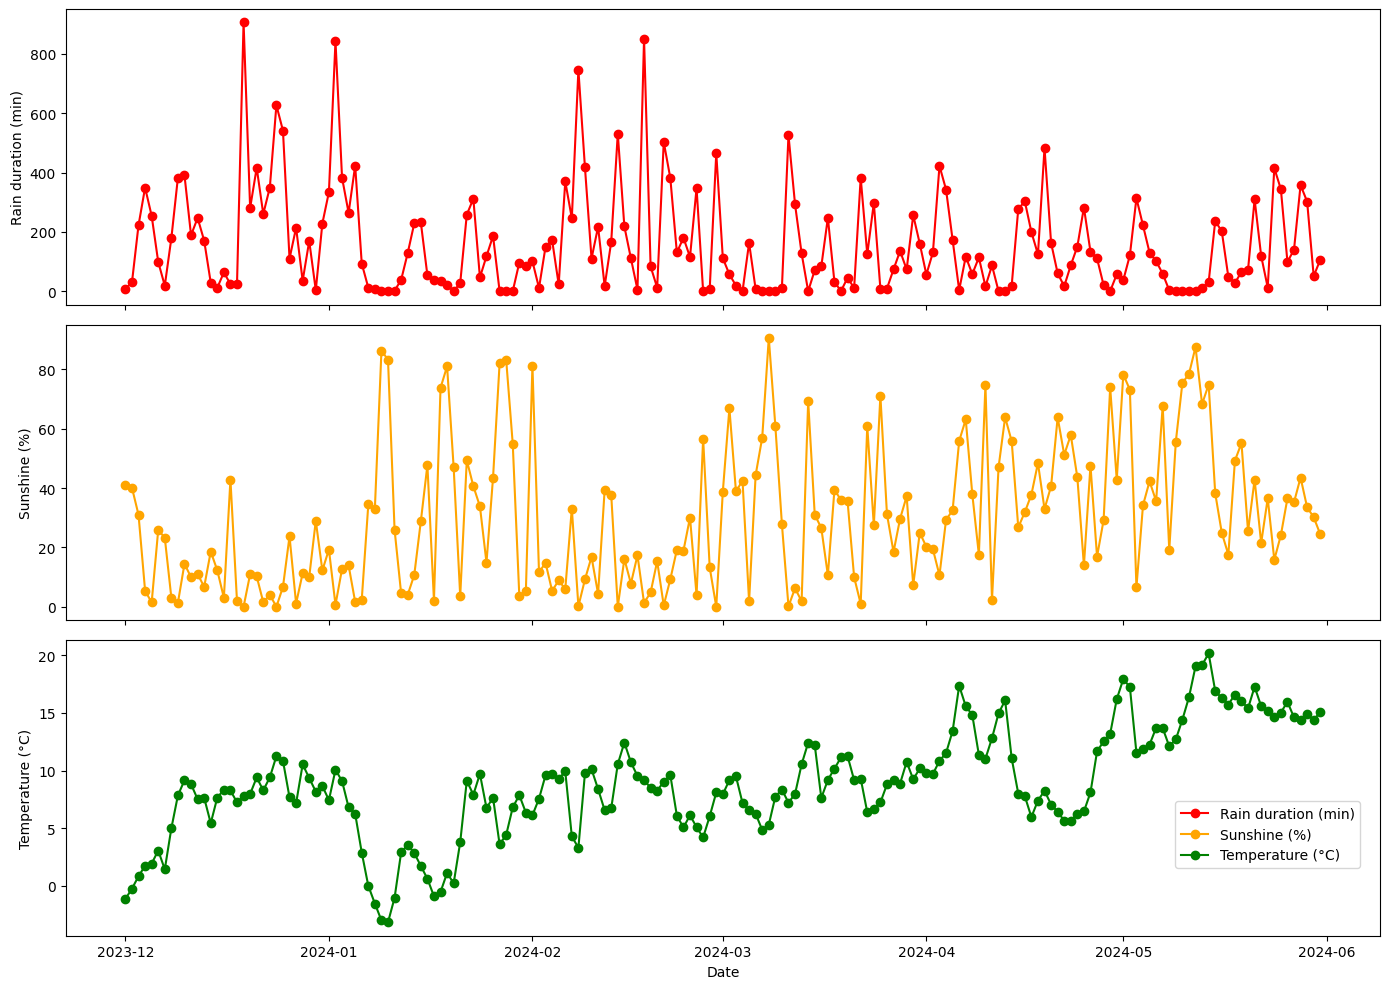

<Figure size 640x480 with 0 Axes>

In [ ]:
#Rain minutes, sunhine percentages and temperature
fig, ax = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

ax[0].plot(df_mlr.index, df_mlr['rain'], 'r-o', label='Rain duration (min)')
ax[0].set_ylabel('Rain duration (min)')
ax[1].plot(df_mlr.index, df_mlr['sun'], 'orange', marker='o', label='Sunshine (%)')
ax[1].set_ylabel('Sunshine (%)')
ax[2].plot(df_mlr.index, df_mlr['temperature'], 'g-o', label='Temperature (°C)')
ax[2].set_ylabel('Temperature (°C)')
ax[2].set_xlabel('Date')

fig.legend(bbox_to_anchor=(0.98, 0.2))
plt.tight_layout()
plt.show()

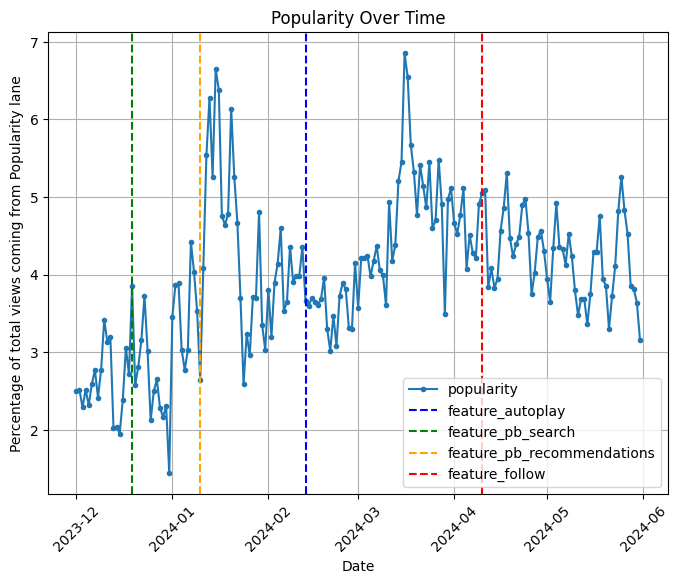

In [ ]:
#Popularity
plt.figure(figsize=(8, 6))
plt.plot(df_mlr.index, df_mlr['popularity'], marker='.', label='popularity')

#Add vertical lines for feature releases
feature_colors = {
    'feature_autoplay': 'blue',
    'feature_pb_search': 'green',
    'feature_pb_recommendations': 'orange',
    'feature_follow': 'red'
}

for feature, release_date in release_dates.items():
    plt.axvline(release_date, linestyle='--', color=feature_colors.get(feature, 'gray'), label=feature)

plt.xlabel('Date')
plt.ylabel('Percentage of total views coming from Popularity lane')
plt.title('Popularity Over Time')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.show()

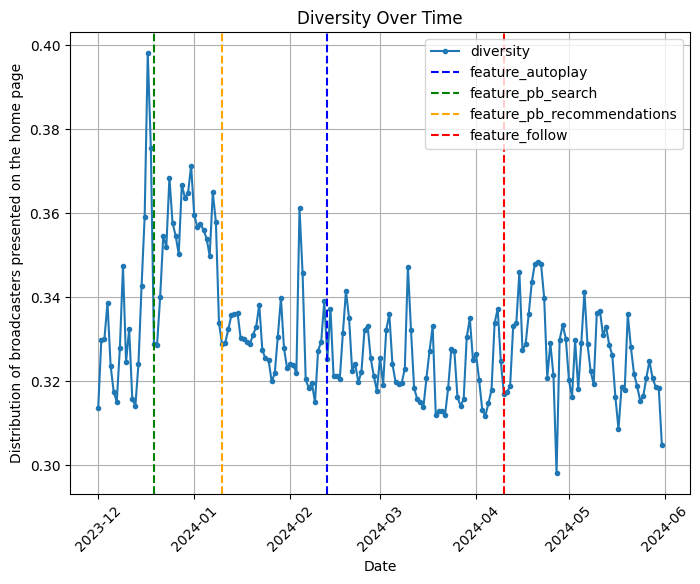

In [ ]:
#Diversity
plt.figure(figsize=(8, 6))
plt.plot(df_mlr.index, df_mlr['diversity'], marker='.', label='diversity')

# Add vertical lines for feature releases
for feature, release_date in release_dates.items():
    plt.axvline(release_date, linestyle='--', color=feature_colors.get(feature, 'gray'), label=feature)

plt.xlabel('Date')
plt.ylabel('Distribution of broadcasters presented on the home page')
plt.title('Diversity Over Time')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.show()